In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("test.csv")

# Show column names and first few rows
print(df.columns)
print(df.head())

Index(['Subject', 'body', 'date', 'from'], dtype='object')
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                body       date  \
0  EnronOptions Announcement\n\n\nWe have updated...  5/10/2010   
1  Marc,\n\nUnfortunately, today is not going to ...  7/29/2010   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...  7/25/2011   
3  we were thinking papasitos (we can meet somewh...  3/25/2010   
4  Since you never gave me the $20 for the last t...  5/21/2011   

                      from  
0     sally.beck@enron.com  
1      eric.bass@enron.com  
2     sally.beck@enron.com  
3  johnny.palmer@enron.com  
4  lydia.delgado@enron.com  


In [3]:
pip install textblob

  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.5
    Uninstalling nltk-3.6.5:
      Successfully uninstalled nltk-3.6.5
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os

os.makedirs("visualization", exist_ok=True)

Data preview:
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                body       date  \
0  EnronOptions Announcement\n\n\nWe have updated...  5/10/2010   
1  Marc,\n\nUnfortunately, today is not going to ...  7/29/2010   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...  7/25/2011   
3  we were thinking papasitos (we can meet somewh...  3/25/2010   
4  Since you never gave me the $20 for the last t...  5/21/2011   

                      from  
0     sally.beck@enron.com  
1      eric.bass@enron.com  
2     sally.beck@enron.com  
3  johnny.palmer@enron.com  
4  lydia.delgado@enron.com  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (to

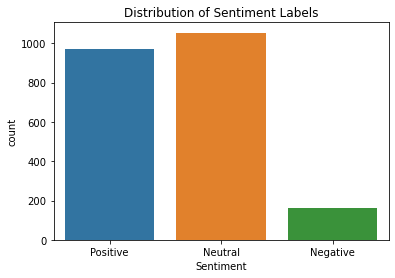

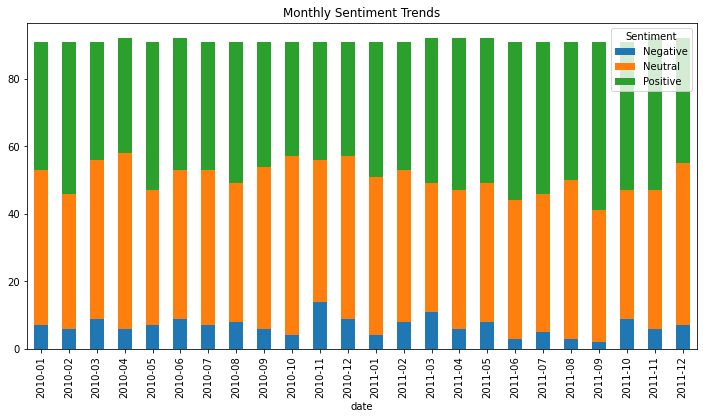

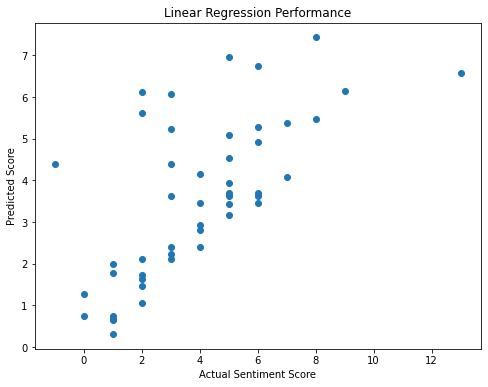

In [14]:
# Employee Sentiment Analysis Project

# SECTION 1: Imports and Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob
import os

# Load dataset
df = pd.read_csv("test.csv")

# Display initial info
print("Data preview:")
print(df.head())
print("\nData info:")
print(df.info())

# SECTION 2: Sentiment Labeling using TextBlob (Task 1)
def get_sentiment(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["body"].apply(get_sentiment)
print("\nSentiment label distribution:")
print(df["Sentiment"].value_counts())

# Save this labeled dataset
labeled_df = df.copy()

# SECTION 3: Exploratory Data Analysis (EDA) (Task 2)
df["date"] = pd.to_datetime(df["date"])
sns.countplot(data=df, x="Sentiment")
plt.title("Distribution of Sentiment Labels")
plt.savefig("visualization/sentiment_distribution.png")

# Monthly trends
monthly_sentiment = df.groupby(df["date"].dt.to_period("M"))['Sentiment'].value_counts().unstack().fillna(0)
monthly_sentiment.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Monthly Sentiment Trends")
plt.savefig("visualization/monthly_sentiment.png")

# SECTION 4: Employee Score Calculation (Task 3)
sentiment_score = {"Positive": 1, "Negative": -1, "Neutral": 0}
df["Score"] = df["Sentiment"].map(sentiment_score)
df["Month"] = df["date"].dt.to_period("M")
monthly_scores = df.groupby(["from", "Month"])["Score"].sum().reset_index()

# SECTION 5: Employee Ranking (Task 4)
def rank_employees(month):
    subset = monthly_scores[monthly_scores["Month"] == month]
    top_positive = subset.sort_values(by=["Score", "from"], ascending=[False, True]).head(3)
    top_negative = subset.sort_values(by=["Score", "from"]).head(3)
    return top_positive, top_negative

# Example for most recent month
recent_month = monthly_scores["Month"].max()
positive_top, negative_top = rank_employees(recent_month)

print("\nTop 3 Positive Employees for", recent_month)
print(positive_top)

print("\nTop 3 Negative Employees for", recent_month)
print(negative_top)

# SECTION 6: Flight Risk Detection (Task 5)
df["Negative_Flag"] = df["Sentiment"] == "Negative"
df = df.sort_values(by=["from", "date"])

flight_risks = []
for emp, emp_df in df.groupby("from"):
    dates = emp_df[emp_df["Negative_Flag"]]["date"].tolist()
    for i in range(len(dates) - 3):
        if (dates[i + 3] - dates[i]).days <= 30:
            flight_risks.append(emp)
            break

flight_risks = sorted(set(flight_risks))
print("\nEmployees flagged as flight risk:")
print(flight_risks)

# SECTION 7: Predictive Modeling (Task 6)
# Feature: number of messages per month per employee
message_counts = df.groupby(["from", "Month"]).size().reset_index(name="Msg_Count")
predict_df = pd.merge(monthly_scores, message_counts, on=["from", "Month"])

# Convert month to ordinal
predict_df["Month_Ordinal"] = predict_df["Month"].apply(lambda x: x.to_timestamp().toordinal())

X = predict_df[["Month_Ordinal", "Msg_Count"]]
y = predict_df["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nModel Evaluation:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Score")
plt.title("Linear Regression Performance")
plt.savefig("visualization/model_performance.png")
